# Gridscale Evolution
In this notebook we investigate the temporal evolution of grid-scale circulations.

In [5]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
from matplotlib import gridspec, colors
from xhistogram.xarray import histogram
from src.project_configs import *
from src.utils import *
from src.plotting import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
era5_pcs = load_era5_pcs()
gsam_pcs = load_gsam_pcs()
assert((era5_pcs.time==gsam_pcs.time).all())

# Quiver Plots

In [19]:
pc1_bins = np.arange(-10, 10, 0.5)
pc2_bins = np.arange(-10, 10, 0.5)
midpoint_pc1_bins = array_midpoints(pc1_bins)
midpoint_pc2_bins = array_midpoints(pc2_bins)
xmesh, ymesh = np.meshgrid(midpoint_pc1_bins, midpoint_pc2_bins)
normed = True
arrow_space = 1
obs_cutoff=2

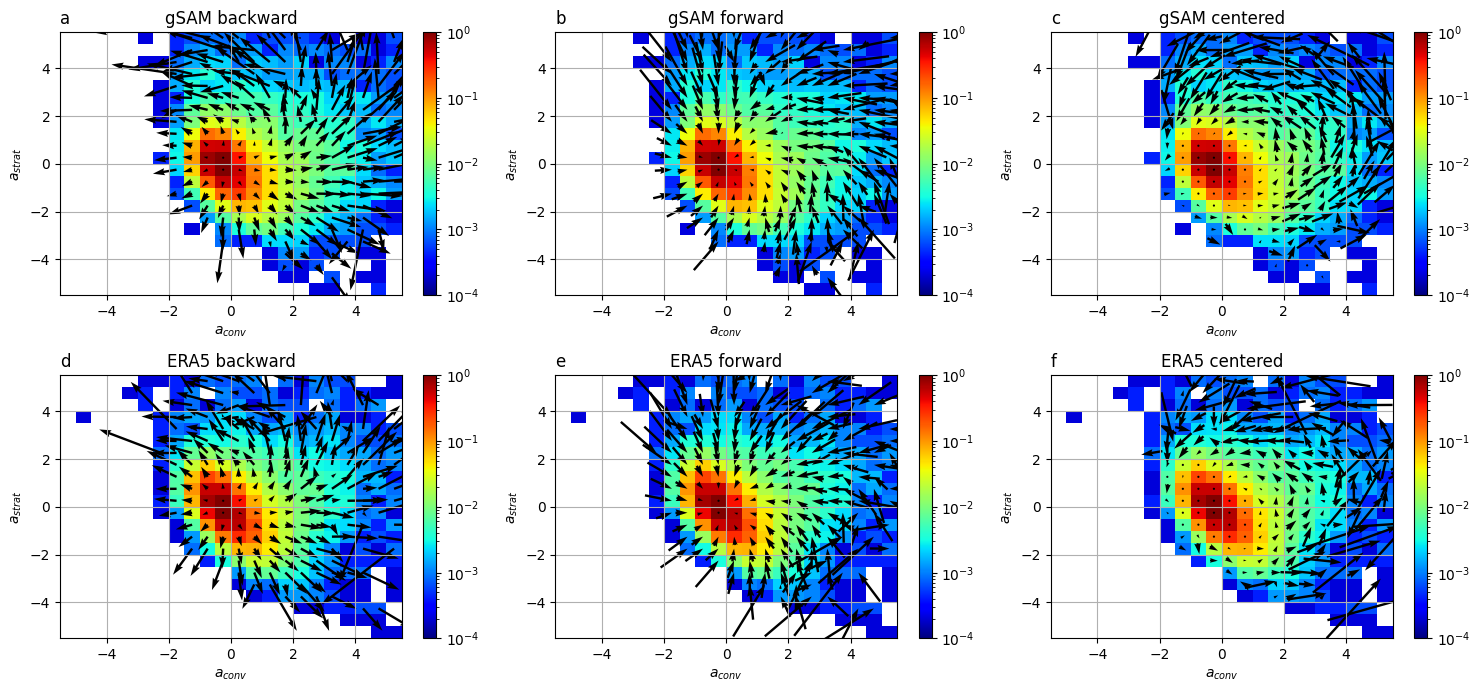

In [32]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 7))
for axi, ax in enumerate(axs.ravel()):
    i, j = np.unravel_index(axi, axs.shape)
    pcs = [gsam_pcs, era5_pcs][i]
    dataset = ['gSAM', 'ERA5'][i]
    method = ['backward', 'forward', 'centered'][j]
    pivot = ['tail', 'tip', 'mid'][j]
    delta_pcs = compute_mean_pc_tendency(pcs, method, normed)
    hist = binned_statistic_2d(
                pcs.sel(mode=2).data.ravel(),
                pcs.sel(mode=1).data.ravel(),
                None,
                statistic='count', 
                bins=[pc2_bins, pc1_bins]
            ).statistic/delta_pcs.size
    
    pcs = pcs.sel(time=delta_pcs.time)
    bin_mean_data = dict()
    for mode in [1,2]:
        bin_mean_delta_pc = binned_statistic_2d(
            pcs.sel(mode=2).data.ravel(),
            pcs.sel(mode=1).data.ravel(),
            delta_pcs.sel(mode=mode).data.ravel(),
            statistic=lambda x: np.nanmean(x) if x.size>obs_cutoff else np.nan, 
            bins=[pc2_bins, pc1_bins]
        ).statistic
        bin_mean_data[mode] = bin_mean_delta_pc
       
    c = ax.pcolormesh(xmesh, ymesh, 100*hist, norm=colors.LogNorm(vmin=1e-4, vmax=1e0), cmap=plt.cm.jet.copy())

    samp = (slice(None, None, arrow_space), slice(None, None, arrow_space))
    scale = 8

    if method=='centered':
        scale = scale/1.5
    ax.quiver(xmesh[samp], ymesh[samp], bin_mean_data[1][samp], bin_mean_data[2][samp], angles='xy', pivot=pivot, scale=scale, width=0.007, headwidth=3, lw=0.009, edgecolor=None, facecolor='black')
    ax.set_title(chr(ord('a') + axi), loc='left')
    ax.set_title(f'{dataset} {method}')
    ax.set_xlabel(r'$a_{conv}$')
    ax.set_ylabel(r'$a_{strat}$')
    ax.grid()
    ax.set_xlim(-5.5, 5.5)
    ax.set_ylim(-5.5, 5.5)
    fig.colorbar(c)

plt.tight_layout(pad=1)
save_figure(fig, 'gsam_era5_pc_evolution.pdf')

# Octant Definition

In [26]:
pcs = load_gsam_pcs()
theta = compute_theta(pcs)
r = compute_r(pcs)
w = load_gsam_coarse_50pix('W')
w = w.W*w.rho
w = w.where(r>0.5, np.nan)

In [27]:
theta_bins = np.linspace(-np.pi, np.pi, 50)
binned_w = 100*w.groupby_bins(theta, bins=theta_bins).mean()

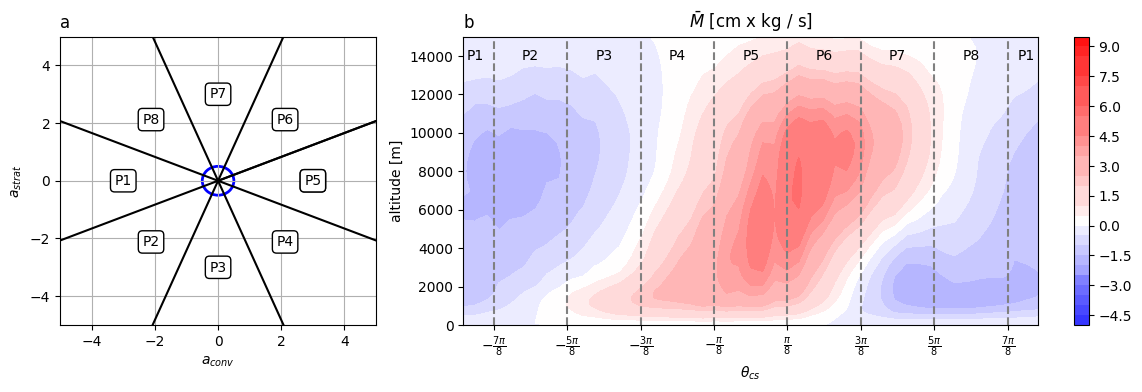

In [33]:
# Create figure and a 1x3 grid where the last two grids are merged
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # Left grid smaller, right 2/3 combined

# Create an empty subplot for the left grid (can be used for other purposes if needed)
ax = fig.add_subplot(gs[0])
# Draw the circle around the origin with radius 1/2
circle = plt.Circle((0, 0), 0.5, color='blue', fill=False, linewidth=2)
ax.add_artist(circle)

# Define the angles for the octant lines (in radians), rotated by 22.5 degrees (pi/8)
rotation_angle = np.pi / 8
angles = np.linspace(0, 2 * np.pi, 9) + rotation_angle  # Add the rotation angle to all octant angles

# Draw lines that divide the grid into rotated octants
for i, angle in enumerate(angles):
    x = np.cos(angle)
    y = np.sin(angle)
    ax.plot([0, 10*x], [0, 10*y], color='black', linestyle='-')
    ax.text(3*np.cos(angle-rotation_angle), 3*np.sin(angle-rotation_angle), f'P{np.mod(i-4, 8)+1}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
# Set limits and add grid for reference
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.grid(True)
ax.set_xlabel(r'$a_{conv}$')
ax.set_ylabel(r'$a_{strat}$')
ax.set_title('a', loc='left')



##############################################
# Create a large subplot that spans the last two grids
ax = fig.add_subplot(gs[1:])

levels = np.arange(-5, 10, 0.5)
norm = colors.TwoSlopeNorm(vmin=levels.min()-1, vmax=levels.max()+1, vcenter=0)
binned_w.plot.contourf(ax=ax, levels=levels, cmap=plt.cm.bwr, norm=norm)
ax.set_ylim(0, 15e3)
pi = np.pi
x_positions = np.array([-7*pi/8, -5*pi/8, -3*pi/8, -pi/8, pi/8, 3*pi/8, 5*pi/8, 7*pi/8])

# Plot vertical dashed grey lines at the specified x-coordinates
for x in x_positions:
    ax.axvline(x=x, color='grey', linestyle='--')

# Set the x-ticks at the specified x-coordinates
ax.set_xticks(x_positions)

# Create LaTeX-formatted labels for the x-ticks
fractions = [
    r'$-\frac{7\pi}{8}$', r'$-\frac{5\pi}{8}$', r'$-\frac{3\pi}{8}$', r'$-\frac{\pi}{8}$',
    r'$\frac{\pi}{8}$', r'$\frac{3\pi}{8}$', r'$\frac{5\pi}{8}$', r'$\frac{7\pi}{8}$'
]
ax.set_xticklabels(fractions)

# Calculate midpoints between the x-positions
midpoints = (x_positions[:-1] + x_positions[1:]) / 2

# Add text at the midpoints of each interval
interval_labels = [f'P{i+2}' for i in range(len(midpoints))]
for x_mid, label in zip(midpoints, interval_labels):
    ax.text(x_mid, 14e3, label, ha='center', va='center')
ax.text((-7.5*pi/8), 14e3, 'P1', ha='center', va='center')
ax.text((7.5*pi/8), 14e3, 'P1', ha='center', va='center')

ax.set_xlabel(r'$\theta_{cs}$')
ax.set_ylabel('altitude [m]')
ax.set_title('b', loc='left')
ax.set_title(r'$\bar M$ [cm x kg / s]', loc='center')

fig.tight_layout(pad=1)

save_figure(fig, 'octant_definition.pdf')